In [1]:
import pandas as pd
import numpy as np
import jsonlines

In [2]:
with jsonlines.open("apolloduck.jl") as f:
    df = pd.DataFrame(f)

In [3]:
df['is_gbp'] = df['price'].str.match("£")

In [4]:
df['price_gbp'] = pd.to_numeric(df['price'].str.replace('[£,]', ''), errors='coerce')

In [5]:
df['description_html'] = df['description_html'].str[0]
df = df.drop_duplicates(subset=['description_html'])

In [6]:
df['description_html'] = (
    df['description_html']
    .str.replace(r'<br />', '\r\n')
    .str.replace(r'<[^>]*>', '')
    .str.replace(r'^Description', '')
)

In [7]:
df['sail_number'] = df['description_html'].str.extract('([0-9]{5,6})')
df['sail_number'] = df['sail_number'].fillna(df['title'].str.extract('([0-9]{5,6})').iloc[:, 0])
df['sail_number'] = pd.to_numeric(df['sail_number'])

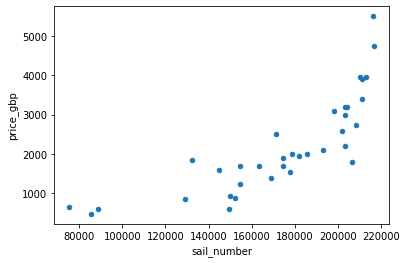

In [8]:
df.plot.scatter('sail_number', 'price_gbp')

In [9]:
all_text = df['description_html'].str.cat(sep=' ')

In [10]:
df['description_html_processed'] = df['description_html'].str.replace('[0-9]', '')

In [11]:
df['sail_number_known'] = ~df['sail_number'].isnull()
df['sail_number1'] = df['sail_number'].fillna(df['sail_number'].median())

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import StackingRegressor
import xgboost

In [13]:
import sklearn_pandas as sp

In [14]:
model = Pipeline([
    ('mapper', sp.DataFrameMapper([
        ('sail_number1', None),
        ('sail_number_known', None),
        ('description_html_processed', TfidfVectorizer())
    ], df_out=True)),
    ('normalization', StandardScaler()),
#     ('regression', TransformedTargetRegressor(
#         LassoCV(),
#         func=np.log,
#         inverse_func=np.exp
#     )),
    ('regression', StackingRegressor([
        ('sail_number', Pipeline([
            ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=10, n_jobs=-1), max_features=1)),
            ('sail_number_regression', xgboost.XGBRegressor())
        ])),
    ], final_estimator=Pipeline([
        ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_features=50))),
        ('regression', RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_features=0.5))
    ]), passthrough=True))
    

    
#     ('regression', TransformedTargetRegressor())
#     ('regression', TransformedTargetRegressor(
#         RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_features=0.5),
#         func=np.log,
#         inverse_func=np.exp
#     ))
])

In [15]:
df_usable = df[~df['price_gbp'].isnull()]

In [16]:
features = Pipeline(model.steps[0:1]).fit_transform(df_usable)

In [17]:
m = model.steps[0][1]
cv = m.built_features[-1][1]

In [18]:
feature_names = ['sail_number1', 'sail_number_known'] + cv.get_feature_names()

In [19]:
results = cross_validate(
    model,
    X=df_usable,
    y=df_usable['price_gbp'],
    scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
    return_estimator=True,
    return_train_score=True
)

In [20]:
pd.DataFrame(results)

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,2.190867,0.331892,"(DataFrameMapper(default=False, df_out=True,\n...",0.465610,0.918323,-926.246444,-241.859486,-1171.532325,-332.668137
1,1.345573,0.297106,"(DataFrameMapper(default=False, df_out=True,\n...",0.502674,0.926321,-598.723556,-277.564486,-732.461845,-357.090249
2,1.371335,0.312656,"(DataFrameMapper(default=False, df_out=True,\n...",0.300156,0.936249,-1056.822444,-205.472429,-1235.867568,-300.104927
3,1.374287,0.306344,"(DataFrameMapper(default=False, df_out=True,\n...",0.837378,0.919143,-360.595111,-278.355714,-414.423509,-378.118105
4,1.372910,0.307929,"(DataFrameMapper(default=False, df_out=True,\n...",0.282310,0.931268,-479.247875,-268.795500,-633.767991,-352.414447


In [21]:
pd.DataFrame(results).mean()

fit_time                               1.530995
score_time                             0.311186
test_r2                                0.477626
train_r2                               0.926261
test_neg_mean_absolute_error        -684.327086
train_neg_mean_absolute_error       -254.409523
test_neg_root_mean_squared_error    -837.610648
train_neg_root_mean_squared_error   -344.079173
dtype: float64

In [22]:
model.fit(df_usable, df_usable['price_gbp'])

Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=True,
                                 features=[('sail_number1', None),
                                           ('sail_number_known', None),
                                           ('description_html_processed',
                                            TfidfVectorizer(analyzer='word',
                                                            binary=False,
                                                            decode_error='strict',
                                                            dtype=<class 'numpy.float64'>,
                                                            encoding='utf-8',
                                                            input='content',
                                                            lowercase=True,
                                                            max_df=1.0,
                                                 

In [23]:
fi = pd.Series(
    model.steps[1][-1].estimator_.feature_importances_,
    feature_names
)


AttributeError: 'StandardScaler' object has no attribute 'estimator_'

In [24]:
fi.sort_values(ascending=False).iloc[0:20]

NameError: name 'fi' is not defined

In [25]:
bla = model.steps[-1][1].regressor_

AttributeError: 'StackingRegressor' object has no attribute 'regressor_'

In [26]:
fs = model.steps[1][1]

In [27]:
coef_vs_fi = pd.DataFrame({
    'feature_importance': fi[fs.get_support()],
    'coef': bla.coef_
})

NameError: name 'fi' is not defined

In [28]:
coef_vs_fi[coef_vs_fi['coef'] != 0]['coef'].sort_values()

NameError: name 'coef_vs_fi' is not defined

In [29]:
df_partial_dependence = pd.concat([
    df_usable.assign(sail_number1=n, index=df_usable.index)
    for n in np.exp(np.linspace(np.log(5000), np.log(220000), 100))
])

In [30]:
df_partial_dependence['predicted_price_gbp'] = model.predict(df_partial_dependence)

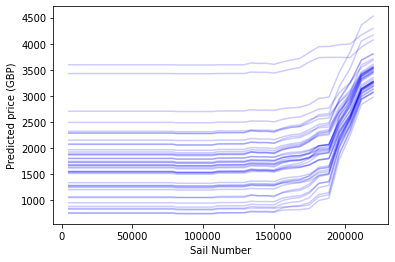

In [31]:
ax = df_partial_dependence.groupby(by=['index', 'sail_number1'])['predicted_price_gbp'].first().unstack('index').plot(alpha=0.2, c='blue')
ax.get_legend().remove()
ax.xaxis.label.set_text('Sail Number')
ax.yaxis.label.set_text('Predicted price (GBP)')

In [32]:
ax.xaxis.label.set_text('Sail Number')

In [33]:
df_usable['pred'] = model.predict(df_usable)

<ipython-input-33-b2ead0384a0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usable['pred'] = model.predict(df_usable)


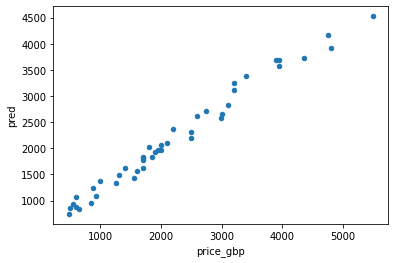

In [34]:
df_usable.plot.scatter('price_gbp', 'pred')

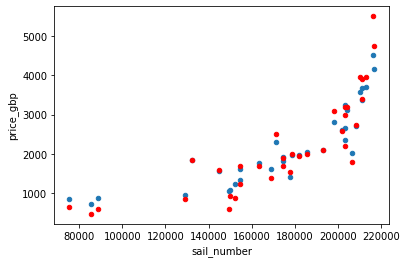

In [35]:
ax = df_usable.plot.scatter('sail_number', 'pred')
ax = df_usable.plot.scatter('sail_number', 'price_gbp', ax=ax, c='r')

In [36]:
df_usable

,title,description_html,price,image_urls,images,is_gbp,price_gbp,sail_number,description_html_processed,sail_number_known,sail_number1,pred
0,174680 Standard and Radial,"""Race Red"" Hull - Used by RYA National Squad S...","£1,700",[https://ics.apolloduck.com/j2e3Bdwd14GNZlyQMM...,NaN,True,1700.0,174680.0,"""Race Red"" Hull - Used by RYA National Squad S...",True,174680.0,1822.164
1,Laser 1,Laser 203298 Standard Rig\r\nGood condition XD...,"£2,200",[https://ics.apolloduck.com/JxNCzCA2PdgWUEsuDb...,NaN,True,2200.0,203298.0,Laser Standard Rig\r\nGood condition XD race ...,True,203298.0,2361.369
2,Laser Standard and Radial,Laser 144744 for sale with combi trailer (road...,"£1,600",[https://ics.apolloduck.com/3D8RPAYq2OyA1k8qn-...,NaN,True,1600.0,144744.0,Laser for sale with combi trailer (road base ...,True,144744.0,1571.620
3,2 New Legal XD Lasers Radial & extra rig,Never been sailed!\r\nClass legal World sailin...,"£5,500",[https://ics.apolloduck.com/11FonxA6_kTDhoxRmf...,NaN,True,5500.0,216373.0,Never been sailed!\r\nClass legal World sailin...,True,216373.0,4526.159
4,"LASER 1,FULL PACKAGE,ROAD TRAILER, STANDARD AN...","We our selling our very well equipped Laser 1,...","£1,700",[https://ics.apolloduck.com/pXJl-qY_Vf_AjrSI0L...,NaN,True,1700.0,NaN,"We our selling our very well equipped Laser , ...",False,177602.0,1841.947
5,Laser Harken XD Full Rig 210980,Harken XD-rigged Laser with MKII full rig in l...,"£3,900",[https://ics.apolloduck.com/eijsls_Em9GOXK1gOt...,NaN,True,3900.0,210980.0,Harken XD-rigged Laser with MKII full rig in l...,True,210980.0,3683.388
6,Laser Race - One design racing. With TLC PLAQUE!,Pick up a brand new Laser for just £4358.40! A...,"£4,358",[https://ics.apolloduck.com/uQYslwhqlijRr6tR3V...,NaN,True,4358.0,NaN,Pick up a brand new Laser for just £.! A fanta...,False,177602.0,3728.232
7,Laser 1,laser 1 for sale \r\nsail number 129001\r\nxd...,£850,[https://ics.apolloduck.com/Tillnousx64NebsGn0...,NaN,True,850.0,129001.0,laser for sale \r\nsail number \r\nxd outhau...,True,129001.0,958.151
8,Laser 1,"Old but very capable boat, owner for 10 years,...",£550,[https://ics.apolloduck.com/zZ92mK9v8bMJZGbJxk...,NaN,True,550.0,NaN,"Old but very capable boat, owner for years, a...",False,177602.0,928.265
9,Laser 1 Sailing Dinghy,"Laser 208172, complete with standard rig, full...","£2,750",[https://ics.apolloduck.com/OrWC3phN5gWxa65nXz...,NaN,True,2750.0,208172.0,"Laser , complete with standard rig, full XD, G...",True,208172.0,2719.864


In [37]:
df_usable.shape

(44, 12)